# MRS point source spectral extraction
The method to extract a 1D spectrum from a detector slope image is illustrated in this notebook for the case of a point source observation. Two methods are shown, one is aperture photometry, and the other is PSF-weighted (optimal) spectral extraction.  
  
The notebook was created on: November 3rd 2017  
The author of the notebook is: Ioannis Argyriou (Institute of Astronomy, KUL)  
The author's email is: ioannis.argyriou@kuleuven.be

## So let's start! First import all the required python modules

In [13]:
import funcs
import mrsobs
import mrs_aux as maux

import numpy as np
from astropy.io import fits
import scipy.interpolate as scp_interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

band = '1A'

## Second, load the filenames and the data therein to-be used in this notebook

In [2]:
# 1-Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# overwrite as needed
if band == '4C': center = [6,-1.]
else: center = None
if band[0] == '4': fit = '1D'
else: fit = '2D'
    
point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_RAD_06_raster(lvl2path,band,output='filename')
source_signal,background_signal = fits.open(point_source_sci)[0].data[0,:,:],fits.open(point_source_bkg)[0].data[0,:,:]
source_signal_error,background_signal_error = fits.open(point_source_sci)[0].data[1,:,:],fits.open(point_source_bkg)[0].data[1,:,:]

d2cMaps   = funcs.load_obj('d2cMaps_band'+band,path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta (or RA and DEC), and wavelength coordinates
det_dims = (1024,1032) # placeholder for the dimension of the detector

fringe_file,photom_file,psf_file,resol_file = funcs.get_cdps(band,cdpDir,output='filepath')
fringe_img,fringe_err = fits.open(fringe_file)[1].data,fits.open(fringe_file)[2].data # [unitless]
photom_img,photom_err = fits.open(photom_file)[1].data,fits.open(fringe_file)[2].data # [DN/s * pixel/mJy]
pixsiz_img    = fits.open(photom_file)[5].data  # [arcsec^2/pix]
psffits       = fits.open(psf_file)             # [unitless]
specres_table = fits.open(resol_file)[1].data   # [unitless]

source_signal_subtrbkg        = source_signal-background_signal                              # [DN/s/pix_{ij}]
source_signal_error_subtrbkg  = np.sqrt(source_signal_error**2 + background_signal_error**2) # [DN/s/pix_{ij}]

source_signal_divfringe = source_signal_subtrbkg/fringe_img # [DN/s/pix_{ij}] 
source_signal_error_divfringe = np.abs(source_signal_divfringe)*np.sqrt( (source_signal_error_subtrbkg/source_signal_subtrbkg)**2 + (fringe_err/fringe_img)**2) # [DN/s/pix_{ij}]

source_signal_divphotom = source_signal_divfringe/photom_img # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)
source_signal_error_divphotom = np.abs(source_signal_divphotom)*np.sqrt( (source_signal_error_divfringe/source_signal_divfringe)**2 + (photom_err/photom_img)**2) # [mJy/pix]

source_signal_divpixsiz = source_signal_divphotom/pixsiz_img # [mJy/arcsec^2]
source_signal_error_divpixsiz = source_signal_error_divphotom/pixsiz_img # [mJy/arcsec^2]

lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)
sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_amp = funcs.point_source_centroiding(band,source_signal_divfringe,d2cMaps,spec_grid=[lambcens,lambfwhms],fit=fit,center=center)

STEP 1: Rough centroiding
Slice 12 has the largest summed flux
Source position: beta = 0.18arcsec, alpha = -0.24arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 39, 40, 41, 43, 121, 122, 123, 197, 203, 295, 296, 304, 305, 306, 345, 346, 347, 348, 371, 372, 373, 374, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]


In [4]:
unique_betas = np.sort(np.unique(d2cMaps['betaMap'][(d2cMaps['sliceMap']>100*int(band[0])) & (d2cMaps['sliceMap']<100*(int(band[0])+1))]))
    
oversampling,nPixels = [np.zeros(len(lambcens)) for j in range(2)]
for ibin in range(len(lambcens)):
    fov_lims  = [d2cMaps['alphaMap'][(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)].min(),d2cMaps['alphaMap'][(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)].max()]
    fov_bin = (unique_betas.max()-unique_betas.min())*(fov_lims[1]-fov_lims[0])
    spatial_sum = pixsiz_img[(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)].sum()
    oversampling[ibin] = spatial_sum/fov_bin
    nPixels[ibin] = len(pixsiz_img[(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)])

In [7]:
# centroid
source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])
if band == '4B': source_beta_center = -0.63

# aperture extraction
eighty_percent_encircled_energy_fraction = funcs.load_obj('eighty_percent_encircled_energy_fraction')
radius = np.average(eighty_percent_encircled_energy_fraction[band])
print 'Aperture radius: {} arcsec'.format(round(radius,2))
pix_in_aperture,aperture_area = funcs.elliptical_aperture(center=[source_alpha_center,source_beta_center],r=radius,q=1.,pa=0.,d2cMaps=d2cMaps)

apertureMask = np.zeros(det_dims)
apertureMask[pix_in_aperture] = 1.

aperture_extracted_signal = funcs.aperture_photometry_point_source(band,source_signal_divphotom,apertureMask,aperture_area,d2cMaps,spec_grid=[lambcens,lambfwhms])
aperture_extracted_signal_error = funcs.aperture_photometry_point_source(band,source_signal_error_divphotom,apertureMask,aperture_area,d2cMaps,spec_grid=[lambcens,lambfwhms])

# optimal extraction
psf = funcs.evaluate_psf_cdp(psffits,d2cMaps,source_center=[source_alpha_center,source_beta_center])

opspec_signal,opspec_signal_error = funcs.optimal_extraction(band,source_signal_divphotom,source_signal_error_divphotom,psf,d2cMaps,spec_grid=[lambcens,lambfwhms])

Aperture radius: 0.36 arcsec


<IPython.core.display.Javascript object>


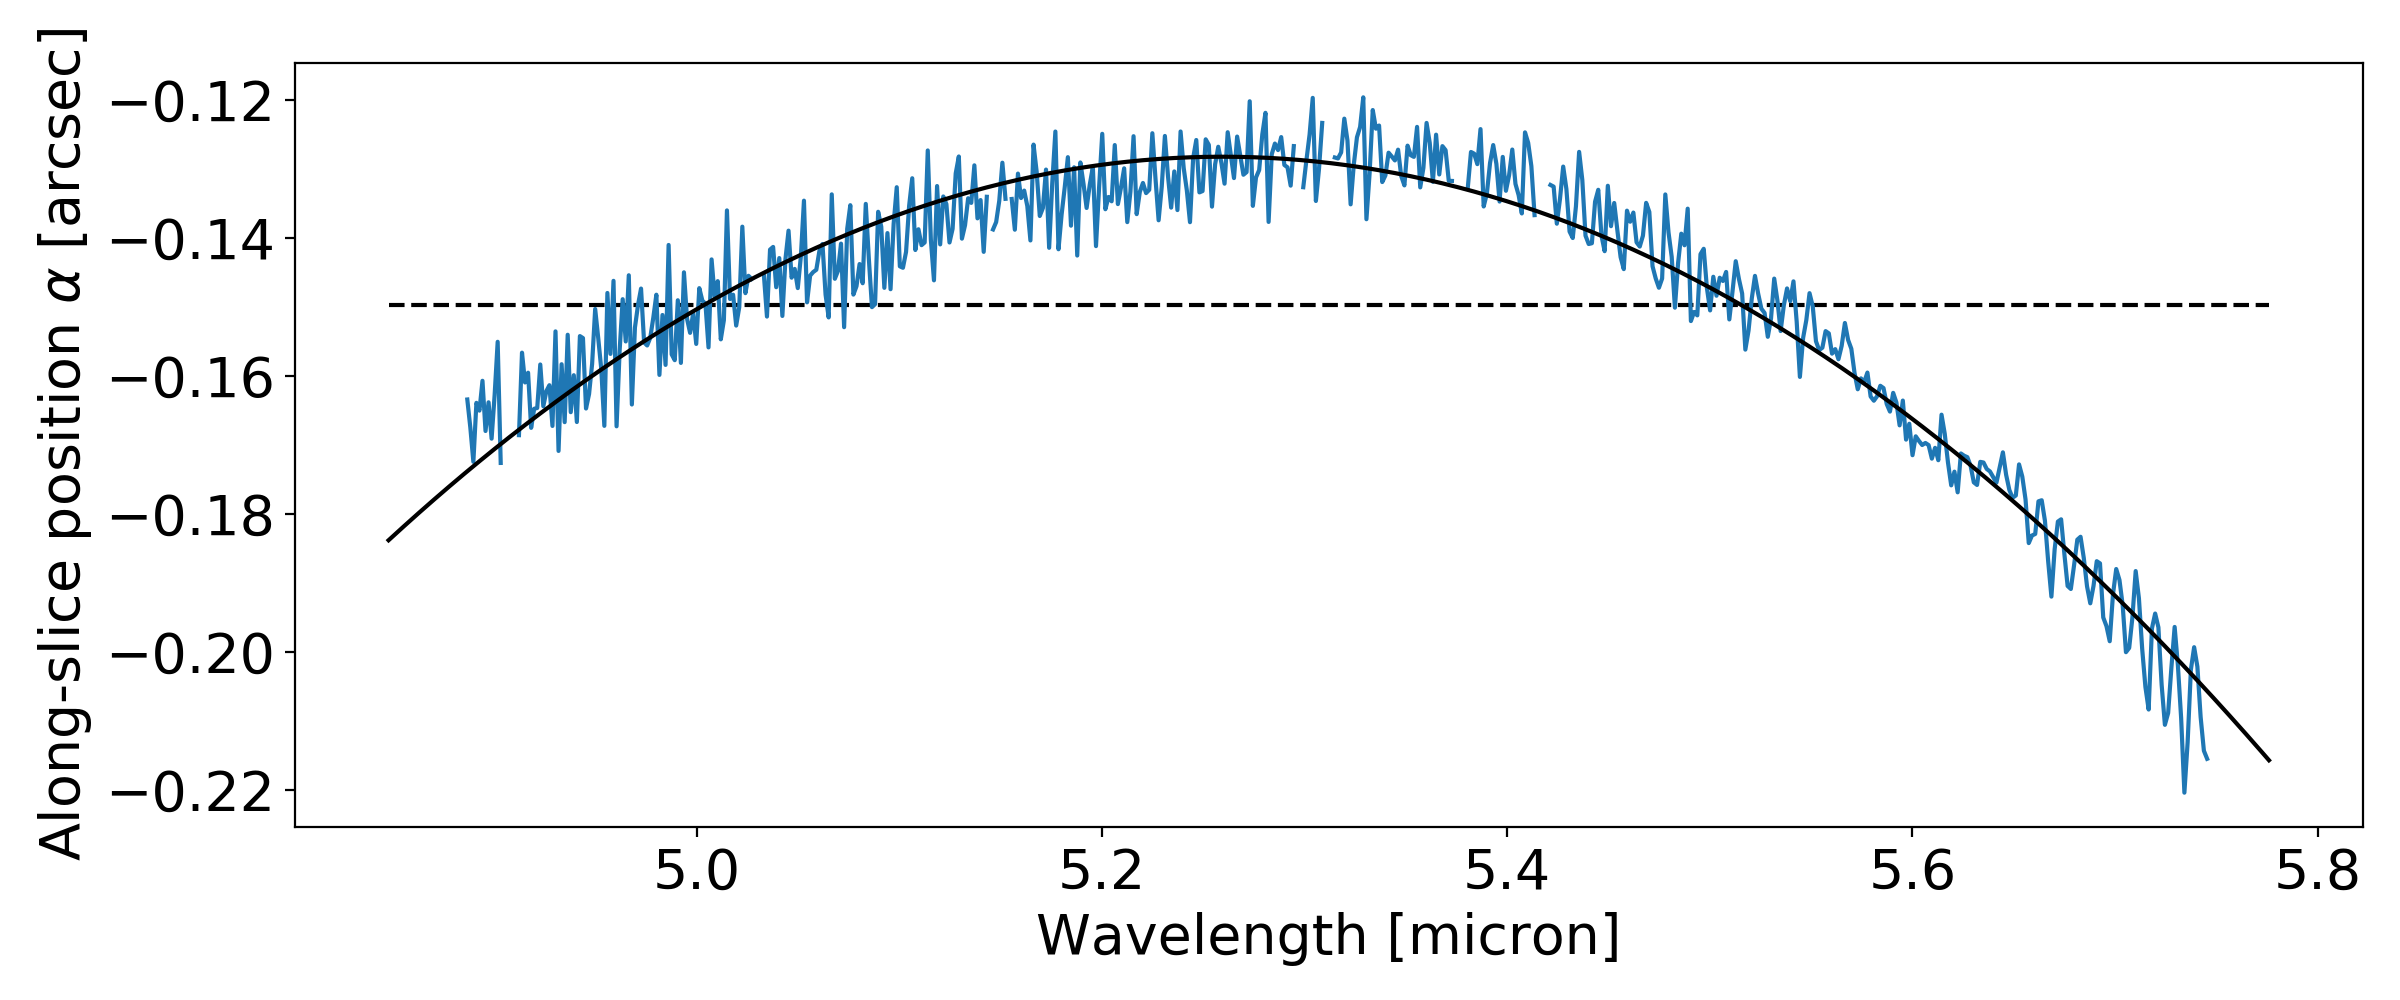

<IPython.core.display.Javascript object>


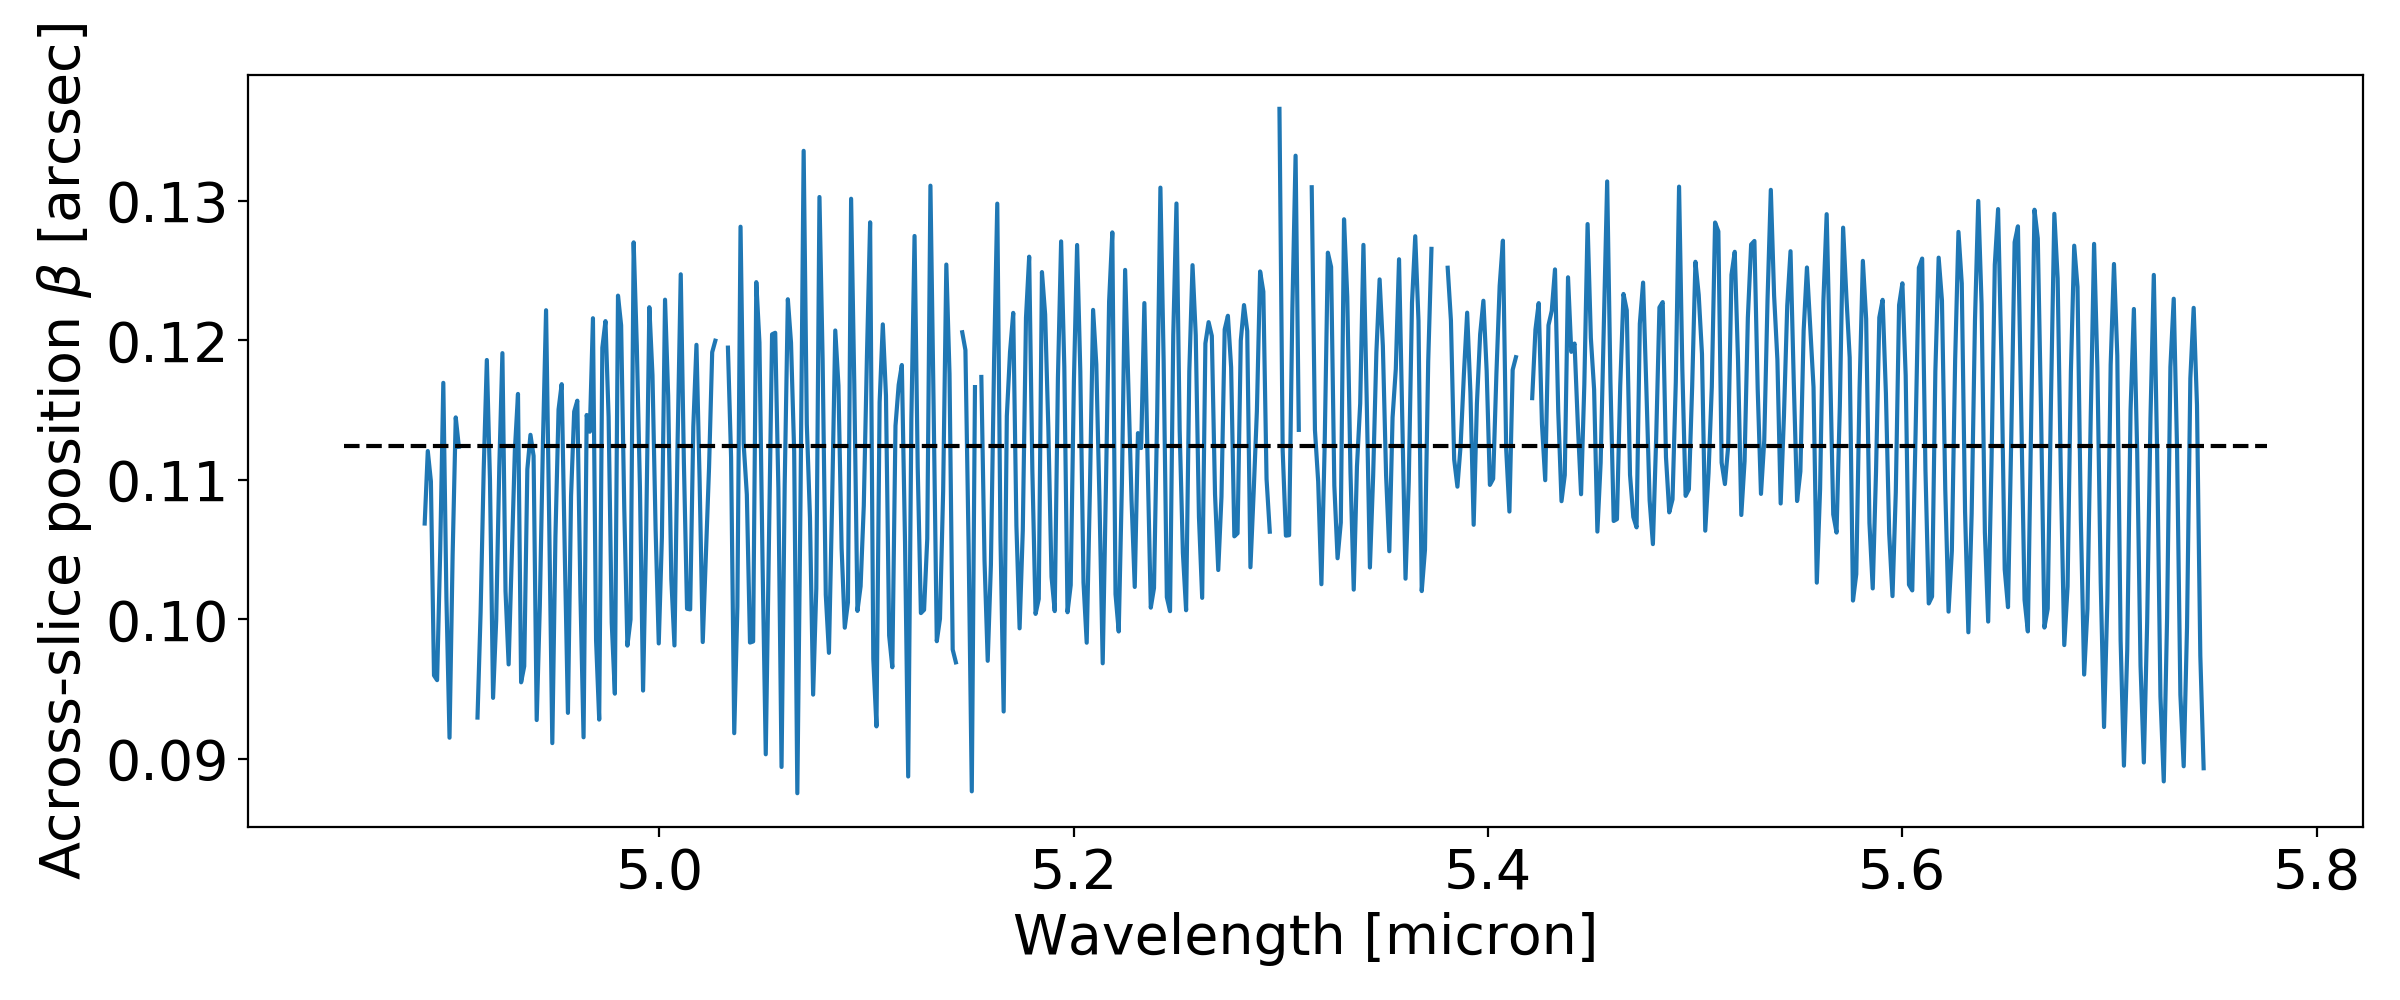

<IPython.core.display.Javascript object>


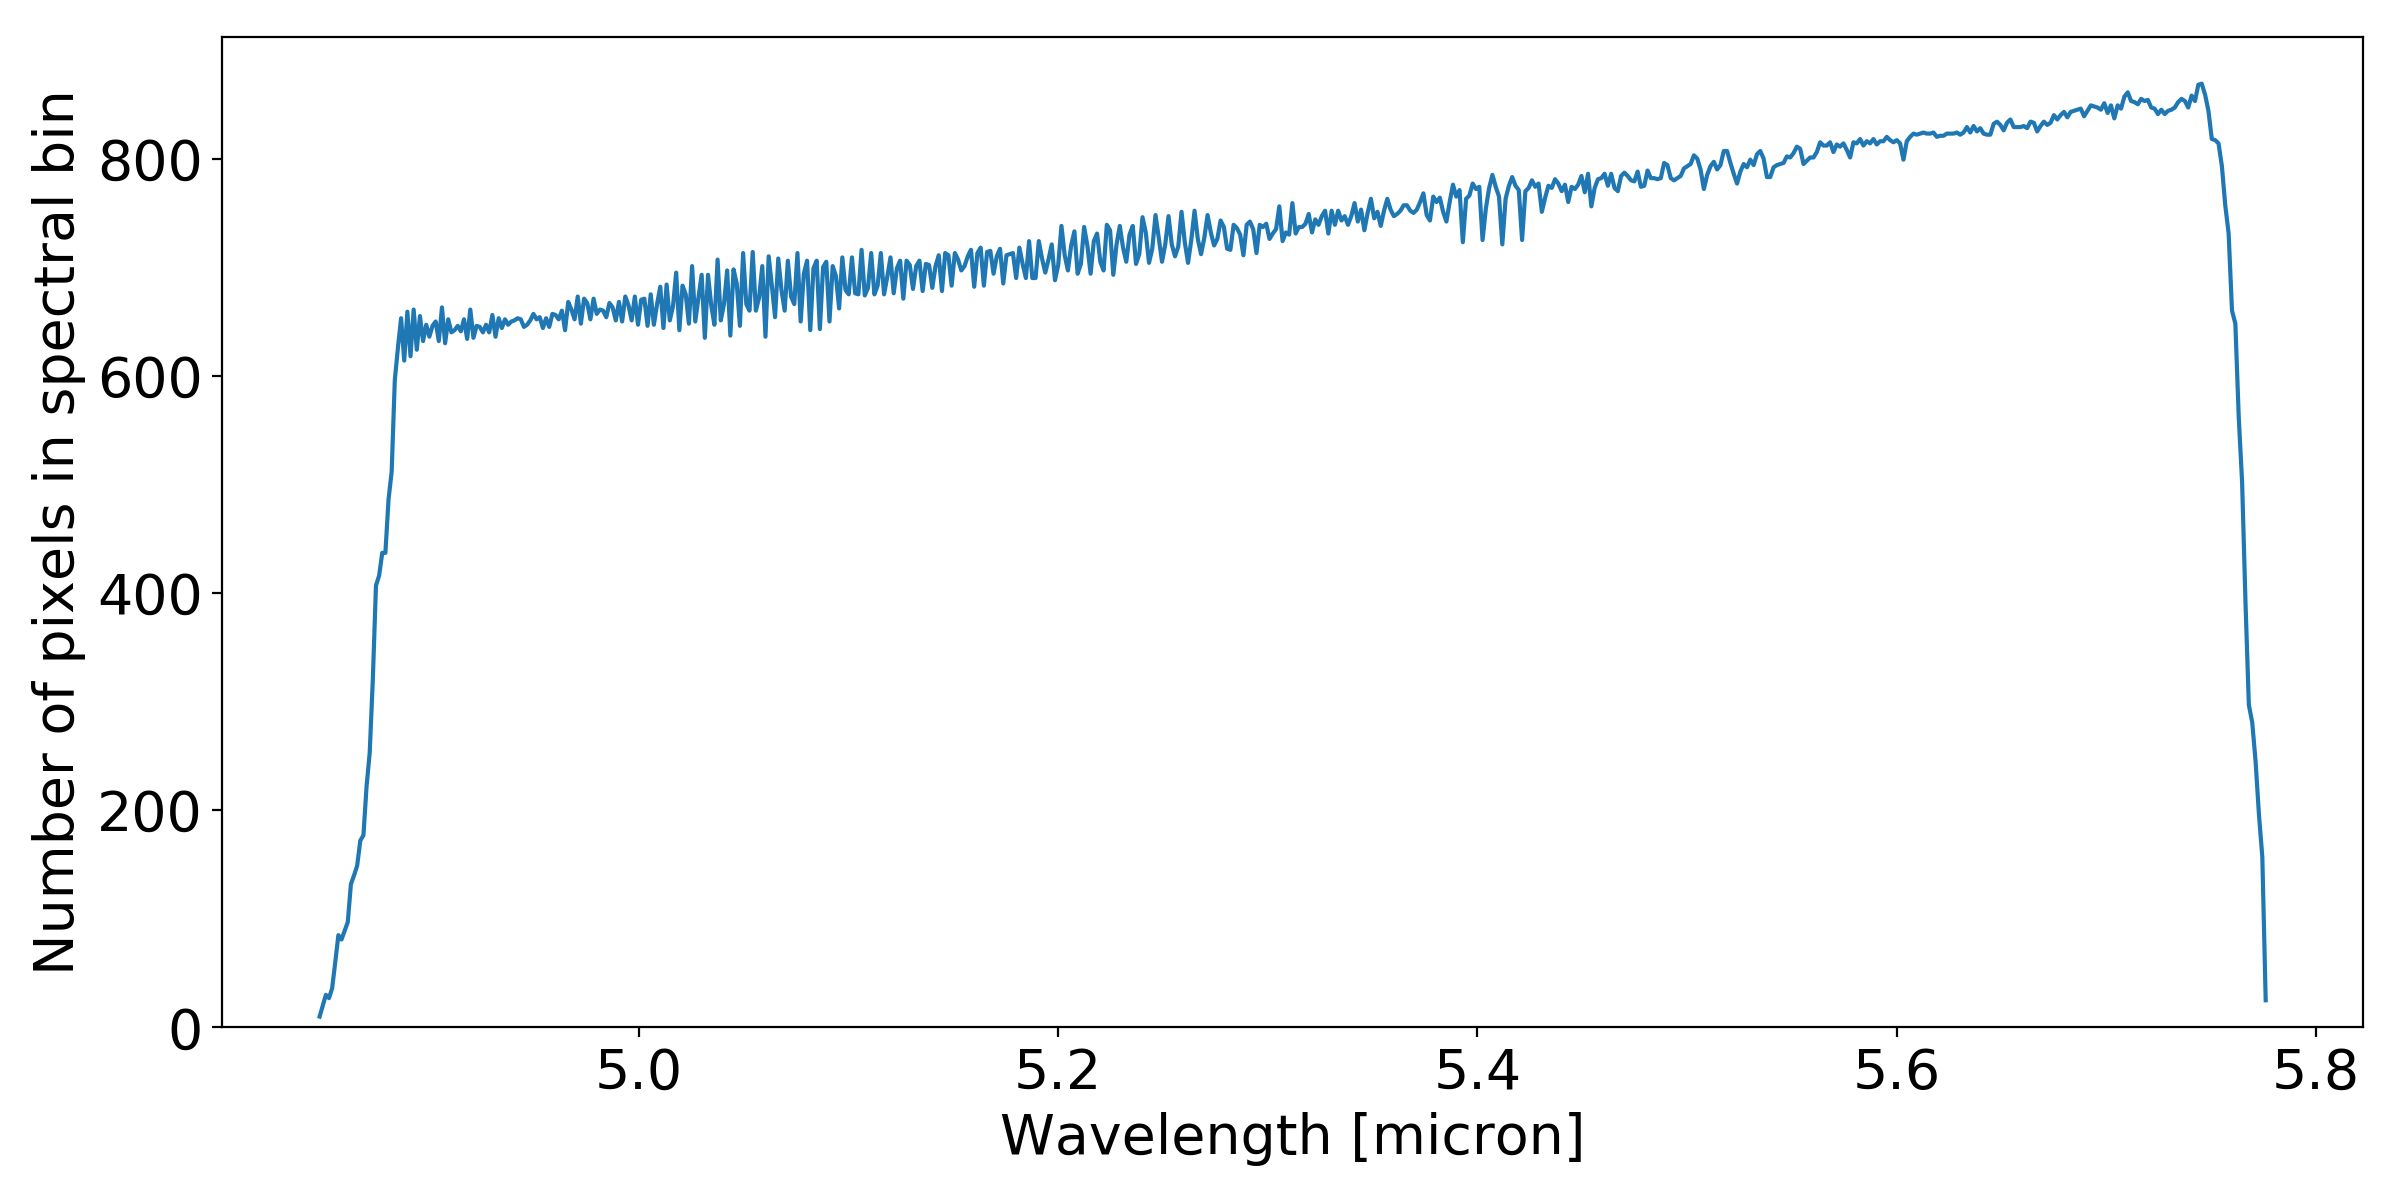

<IPython.core.display.Javascript object>


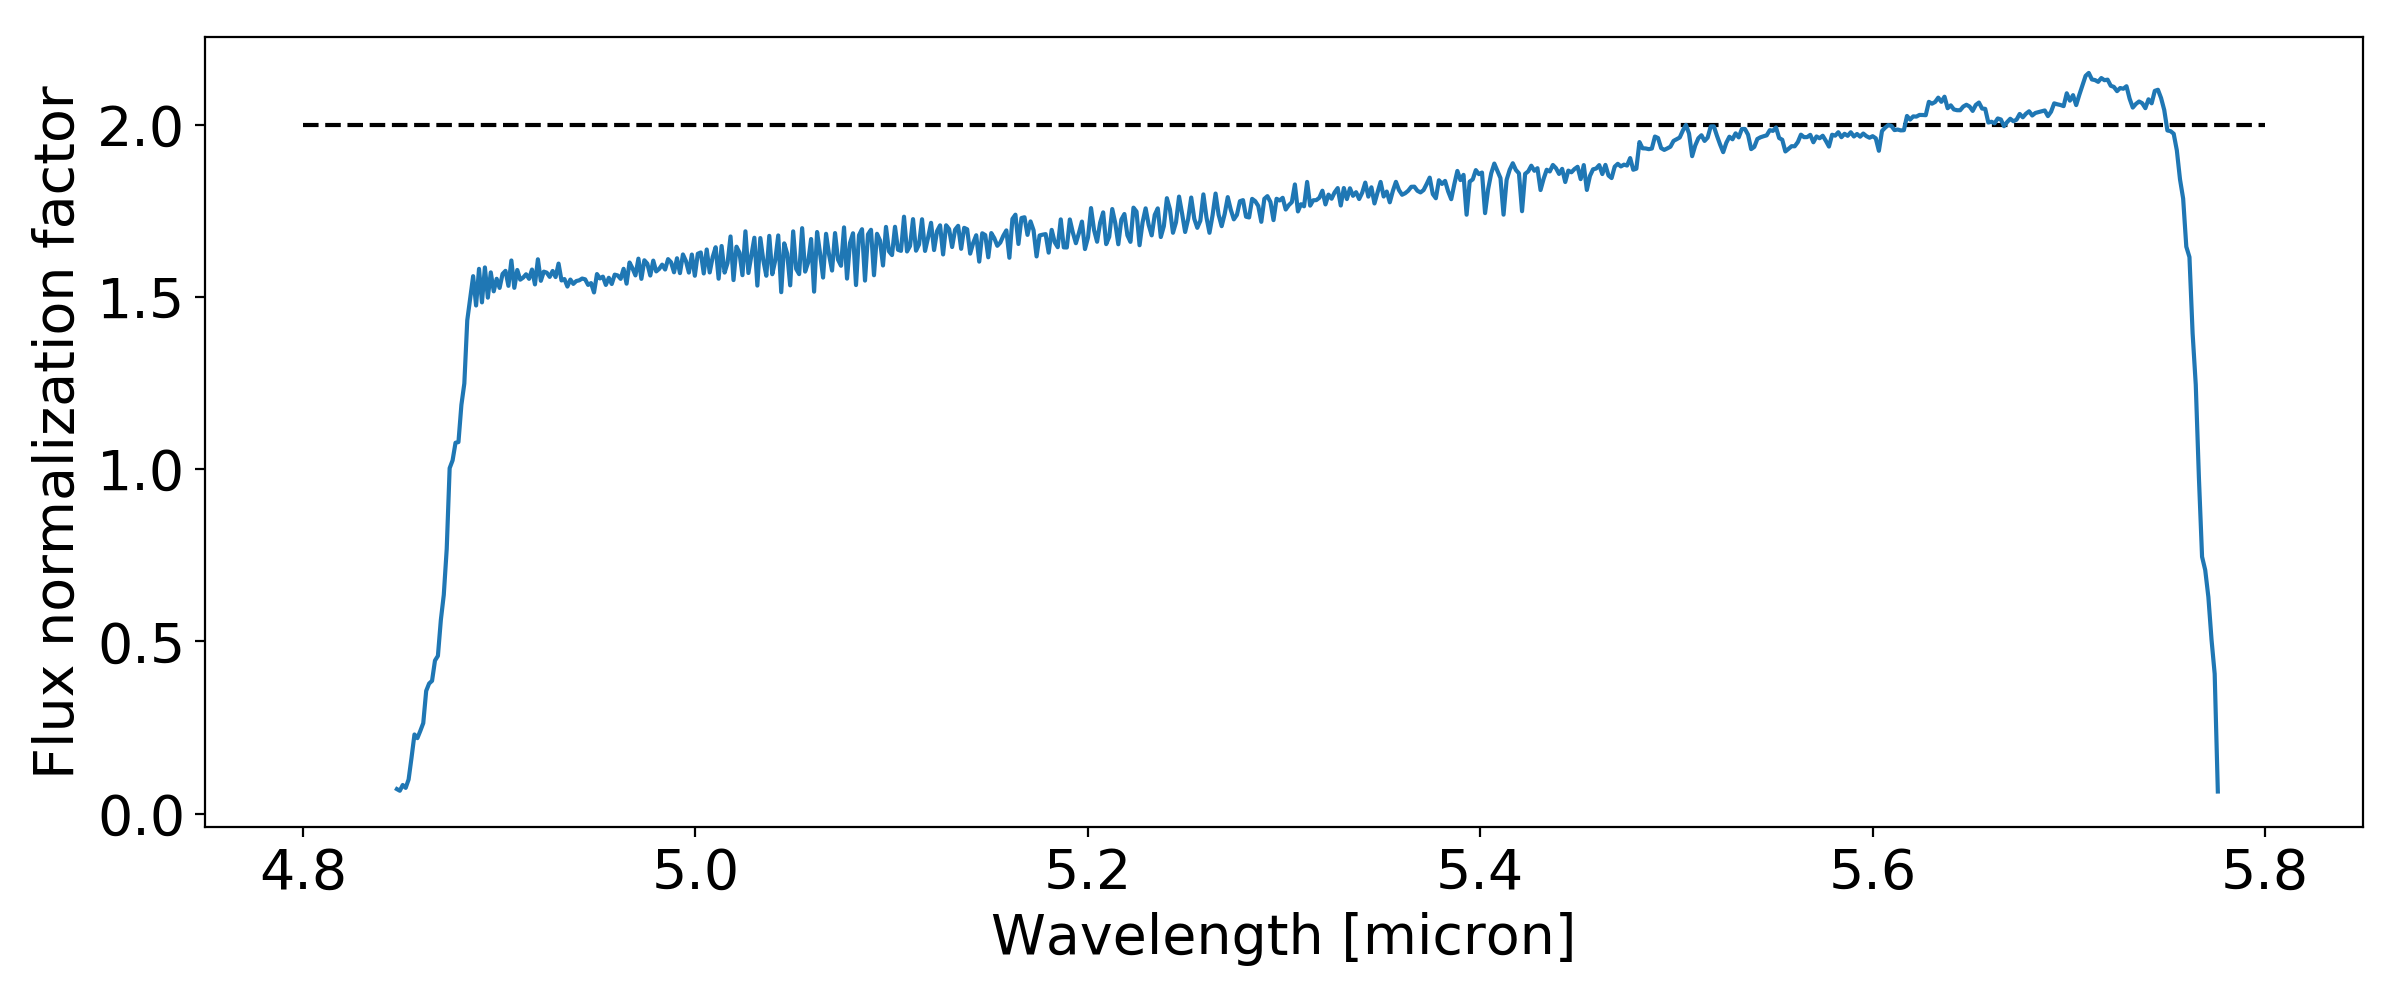

<IPython.core.display.Javascript object>


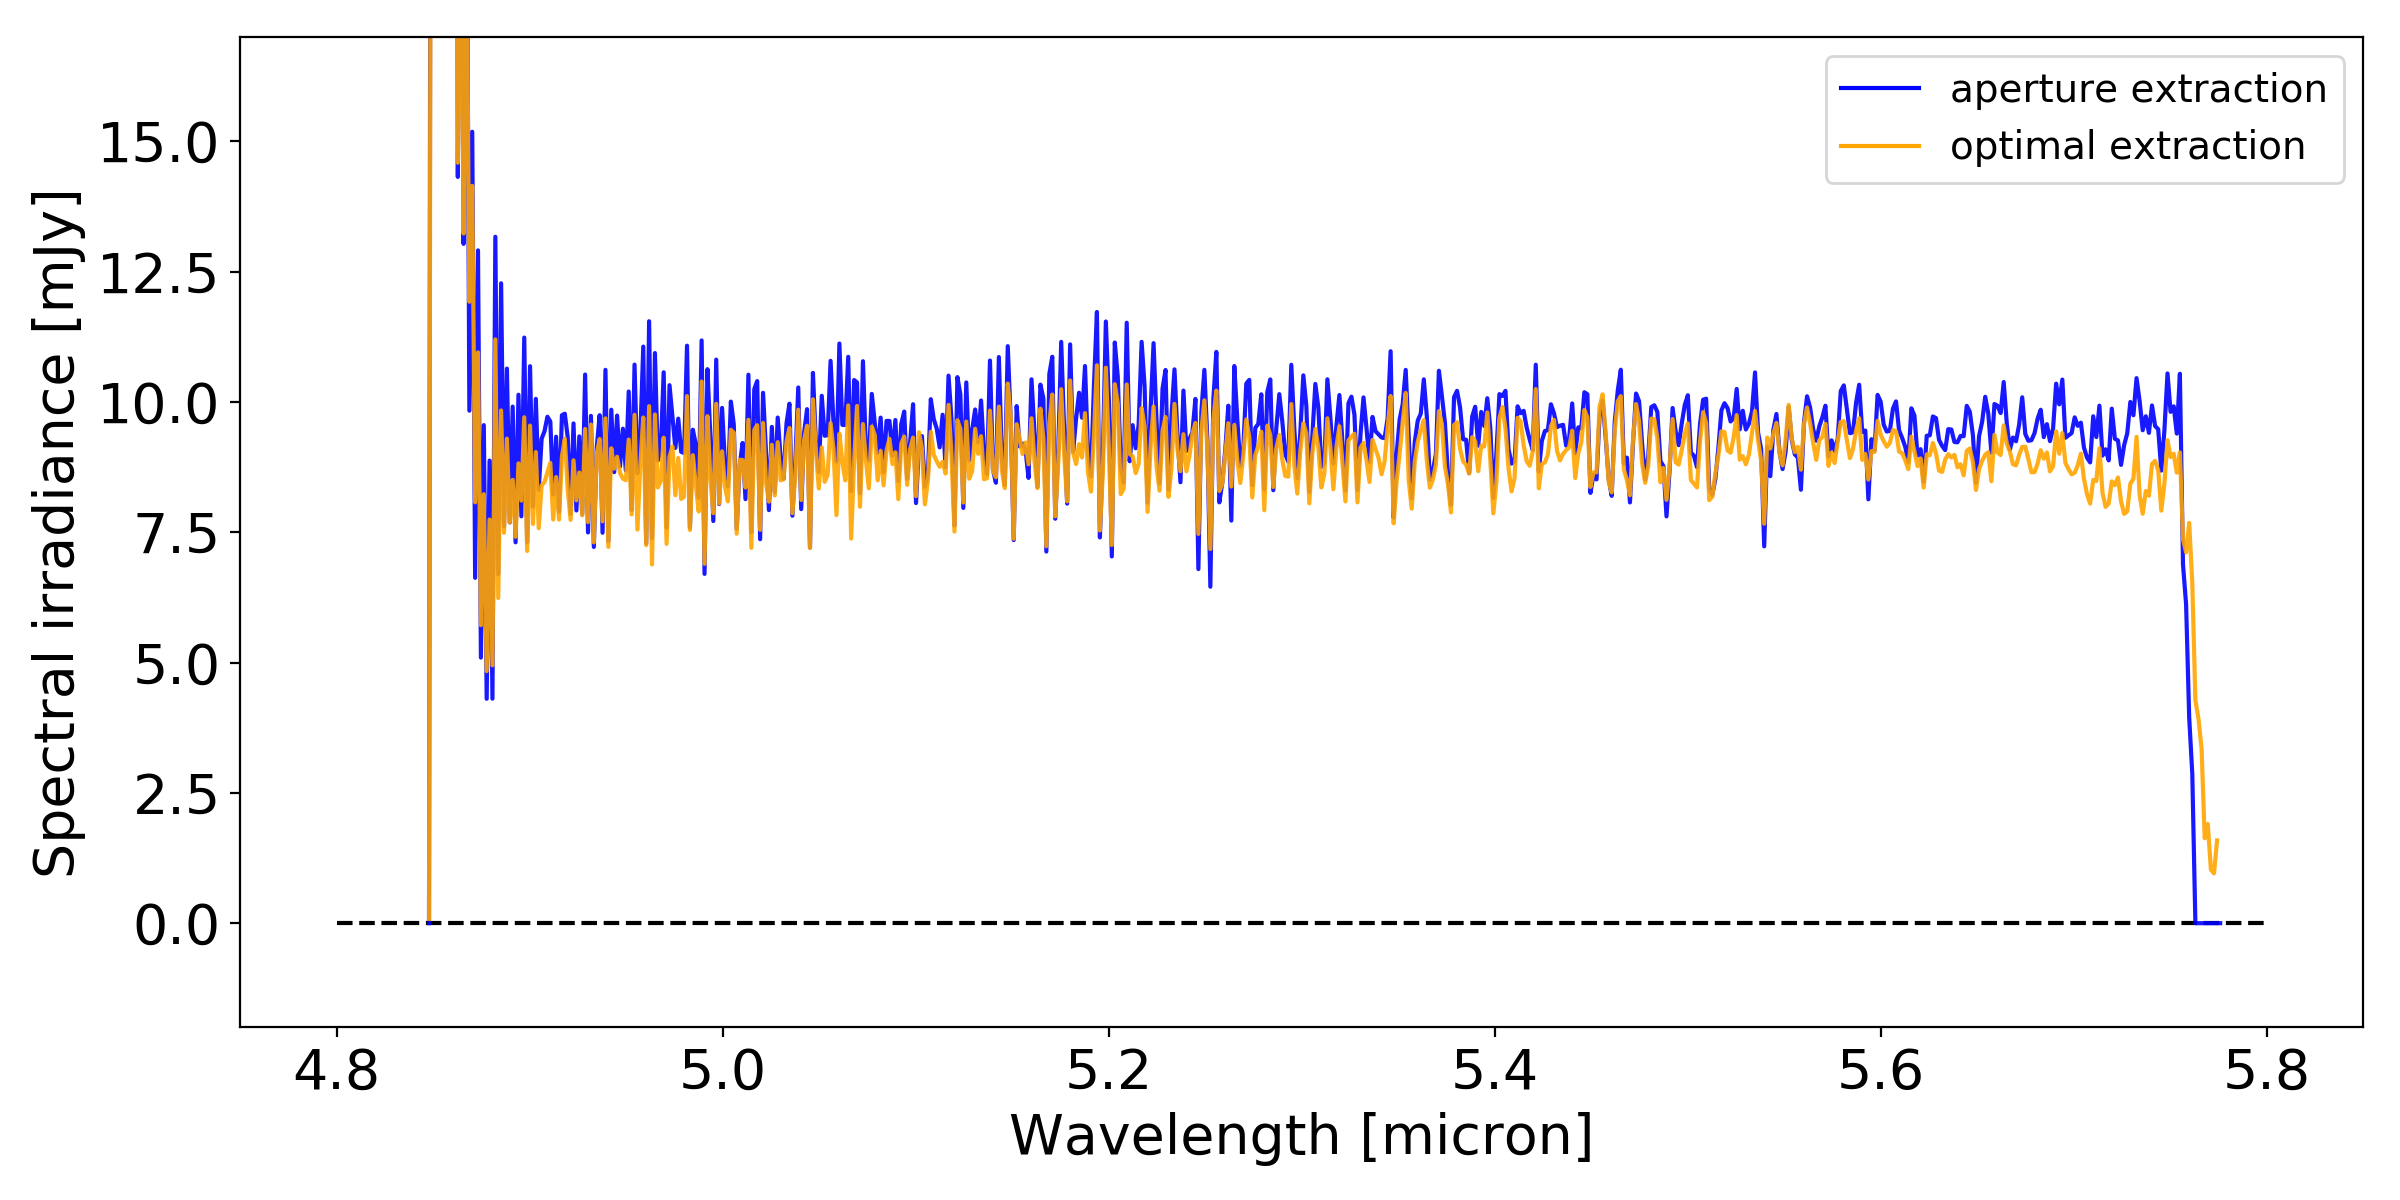

<IPython.core.display.Javascript object>


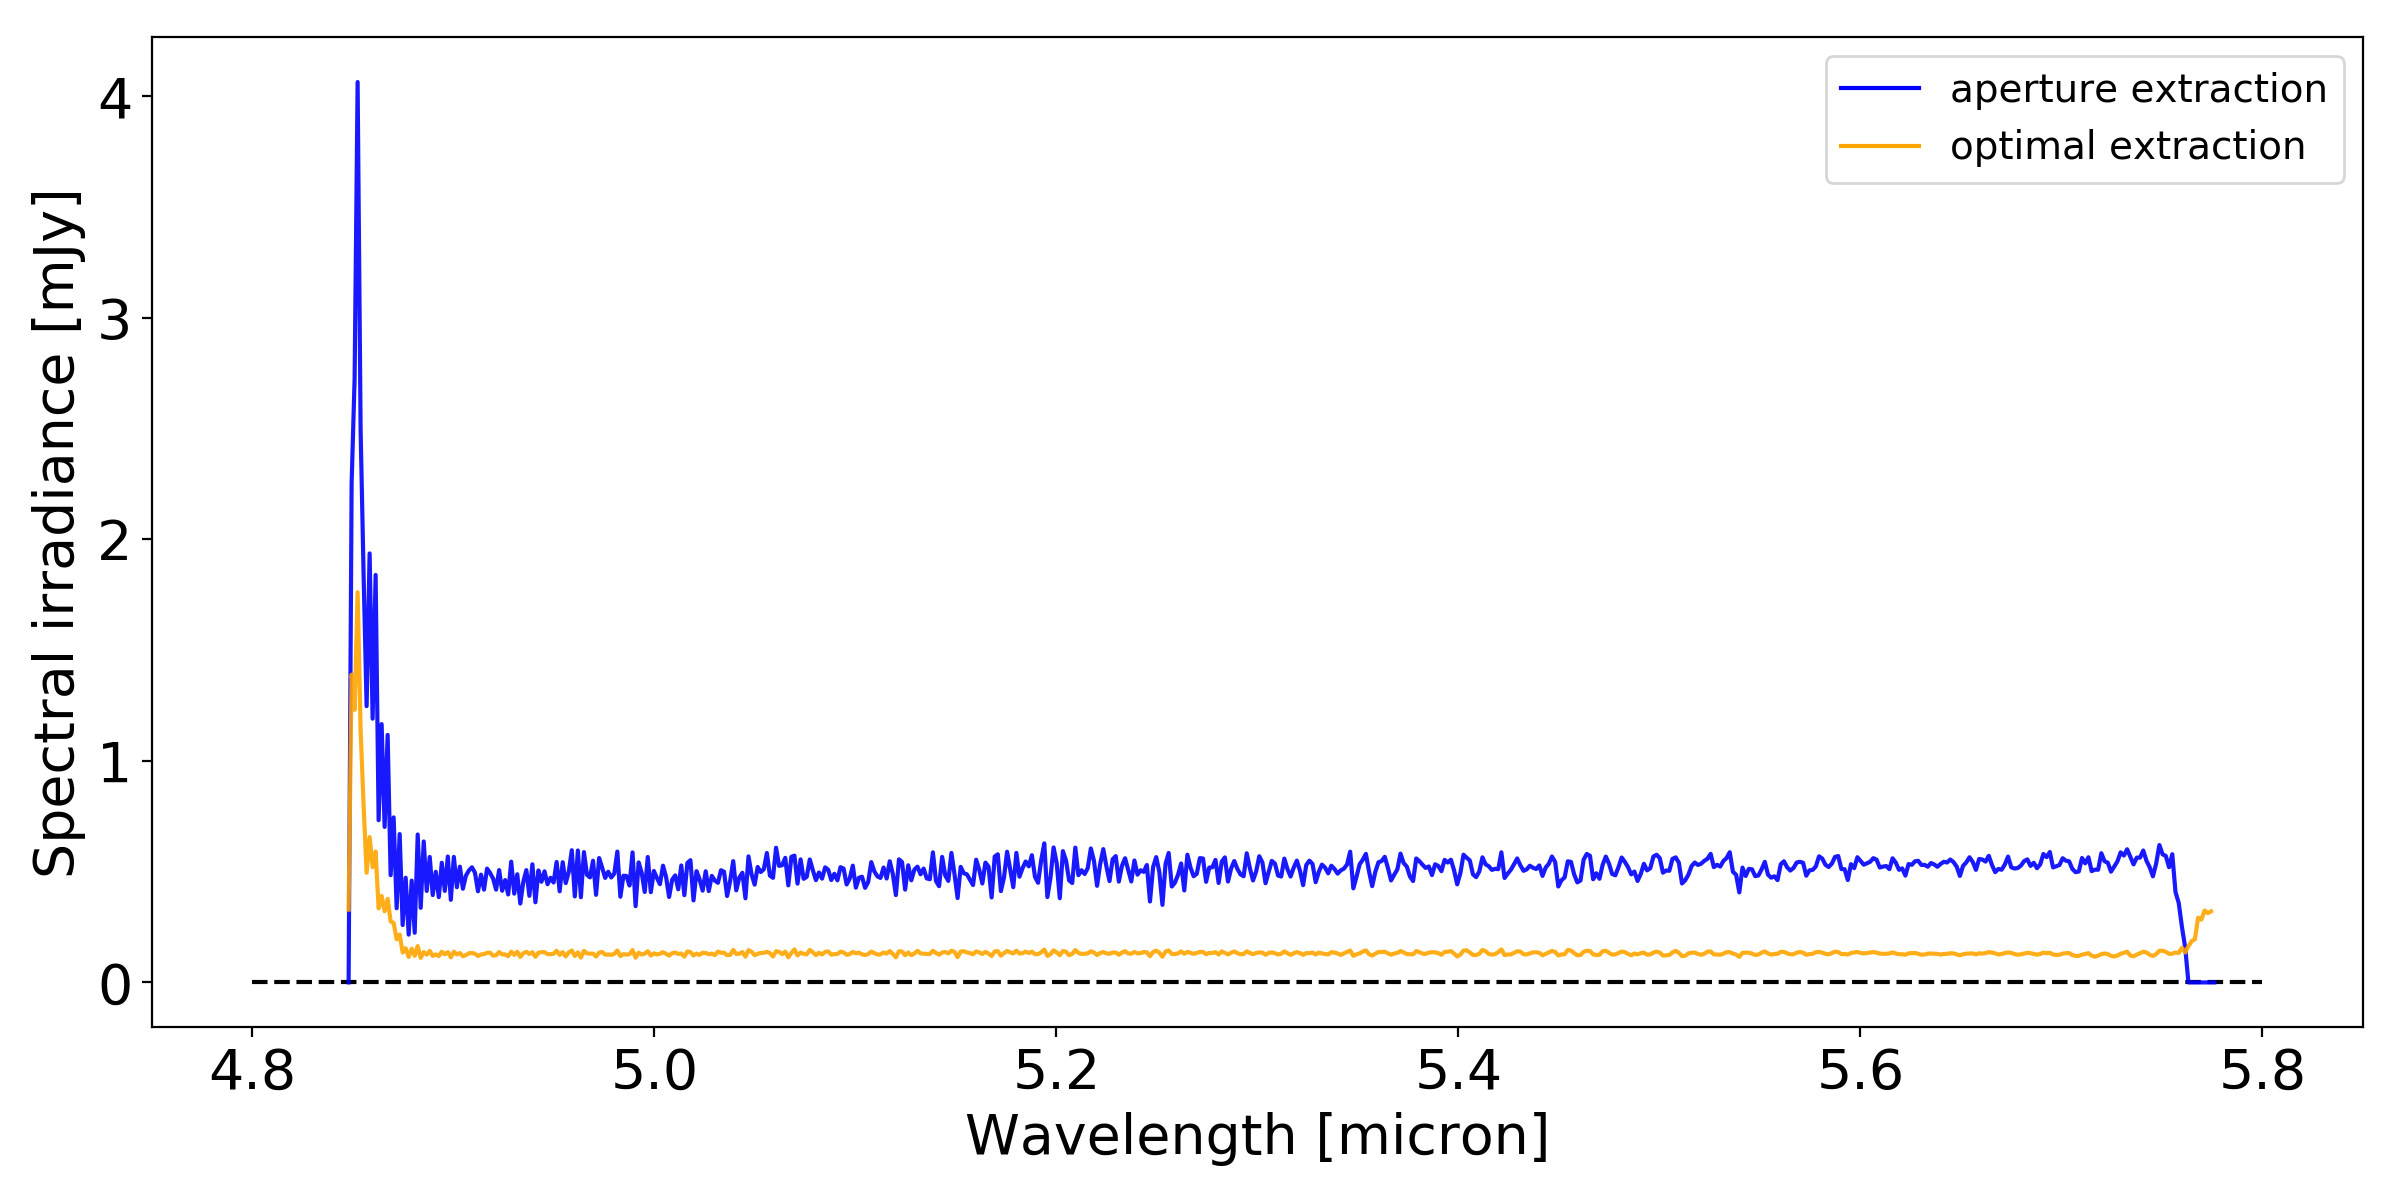

In [19]:
plt.figure(figsize=(12,5))
popt_alpha,pcov_alpha = curve_fit(funcs.order2polyfit, lambcens[~np.isnan(alpha_centers)], alpha_centers[~np.isnan(alpha_centers)],method='lm')

plt.plot(lambcens,alpha_centers)
plt.plot(lambcens,funcs.order2polyfit(lambcens,*popt_alpha),'k')
plt.hlines(np.mean(alpha_centers[~np.isnan(alpha_centers)]),lambcens[0],lambcens[-1],linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Along-slice position $\alpha$ [arcsec]')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.plot(lambcens,beta_centers,zorder=0)
if band == '4B':
    plt.hlines(-0.53,lambcens[0],lambcens[-1],linestyle='dashed',zorder=1)
else:
    plt.hlines(np.mean(beta_centers[~np.isnan(beta_centers)]),lambcens[0],lambcens[-1],linestyle='dashed',zorder=1)
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Across-slice position $\beta$ [arcsec]')
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(lambcens,nPixels)
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Number of pixels in spectral bin')
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.plot(lambcens,oversampling)
plt.hlines(2,4.8,5.8,'k',linestyle='dashed')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Flux normalization factor')
plt.tight_layout()

from matplotlib.lines import Line2D

plt.figure(figsize=(12,6))
plt.plot(lambcens,1.2*aperture_extracted_signal/oversampling,'b',alpha=0.9)
plt.plot(lambcens,opspec_signal/oversampling,'orange',alpha=0.9)
plt.ylim(-2,17)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
plt.hlines(0,4.8,5.8,linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='aperture extraction'),Line2D([0],[0],color='orange',label='optimal extraction')]
plt.legend(handles=legend_elements,loc='upper middle',fontsize=14)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(lambcens,aperture_extracted_signal_error/oversampling,'b',alpha=0.9)
plt.plot(lambcens,opspec_signal_error/oversampling,'orange',alpha=0.9)
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Spectral irradiance [mJy]')
plt.hlines(0,4.8,5.8,linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='aperture extraction'),Line2D([0],[0],color='orange',label='optimal extraction')]
plt.legend(handles=legend_elements,loc='upper middle',fontsize=14)
plt.tight_layout()

# plt.figure(figsize=(12,6))
# for band in bands: # '1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C'
# #     plt.plot(wavelengths[band],std_signals[band])#,'b')
#     plt.plot(wavelengths[band],aper_signals[band]/aper_signals_error[band],'b',alpha=0.9)
#     plt.plot(wavelengths[band],opt_signals[band]/opt_signals_error[band],'orange',alpha=0.9)
# plt.ylim(-2,17)
# plt.xlabel('Wavelength [micron]',fontsize=20)
# plt.ylabel(r'Spectral irradiance [mJy]',fontsize=20)
# plt.hlines(0,4.7,28.8,linestyle='dashed')
# legend_elements = [Line2D([0],[0],color='b',label='aperture extraction'),Line2D([0],[0],color='orange',label='optimal extraction')]
# plt.legend(handles=legend_elements,loc='upper middle',fontsize=14)
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()


In [37]:
band = '1A'
nBins = len(wavelengths[band])
nPoints = 20

counter = 0
wav_apex,std_apex,mean_apex = [],[],[]
while counter < nBins:
    wav_apex.append( np.mean(wavelengths[band][counter:counter+nPoints]) )
    std_apex.append( np.std( (1.2*aper_signals['1A']/oversampling_dic['1A'])[counter:counter+nPoints] ) )
    mean_apex.append( np.mean( (1.2*aper_signals['1A']/oversampling_dic['1A'])[counter:counter+nPoints] ) )
    counter+=nPoints
wav_apex = np.array(wav_apex)
std_apex = np.array(std_apex)
mean_apex = np.array(mean_apex)

counter = 0
wav_opex,std_opex,mean_opex = [],[],[]
while counter < nBins:
    wav_opex.append( np.mean(wavelengths[band][counter:counter+nPoints]) )
    std_opex.append( np.std( (opt_signals['1A']/oversampling_dic['1A'])[counter:counter+nPoints] ) )
    mean_opex.append( np.mean( (opt_signals['1A']/oversampling_dic['1A'])[counter:counter+nPoints] ) )
    counter+=nPoints
wav_opex = np.array(wav_opex)
std_opex = np.array(std_opex)
mean_opex = np.array(mean_opex)

<IPython.core.display.Javascript object>


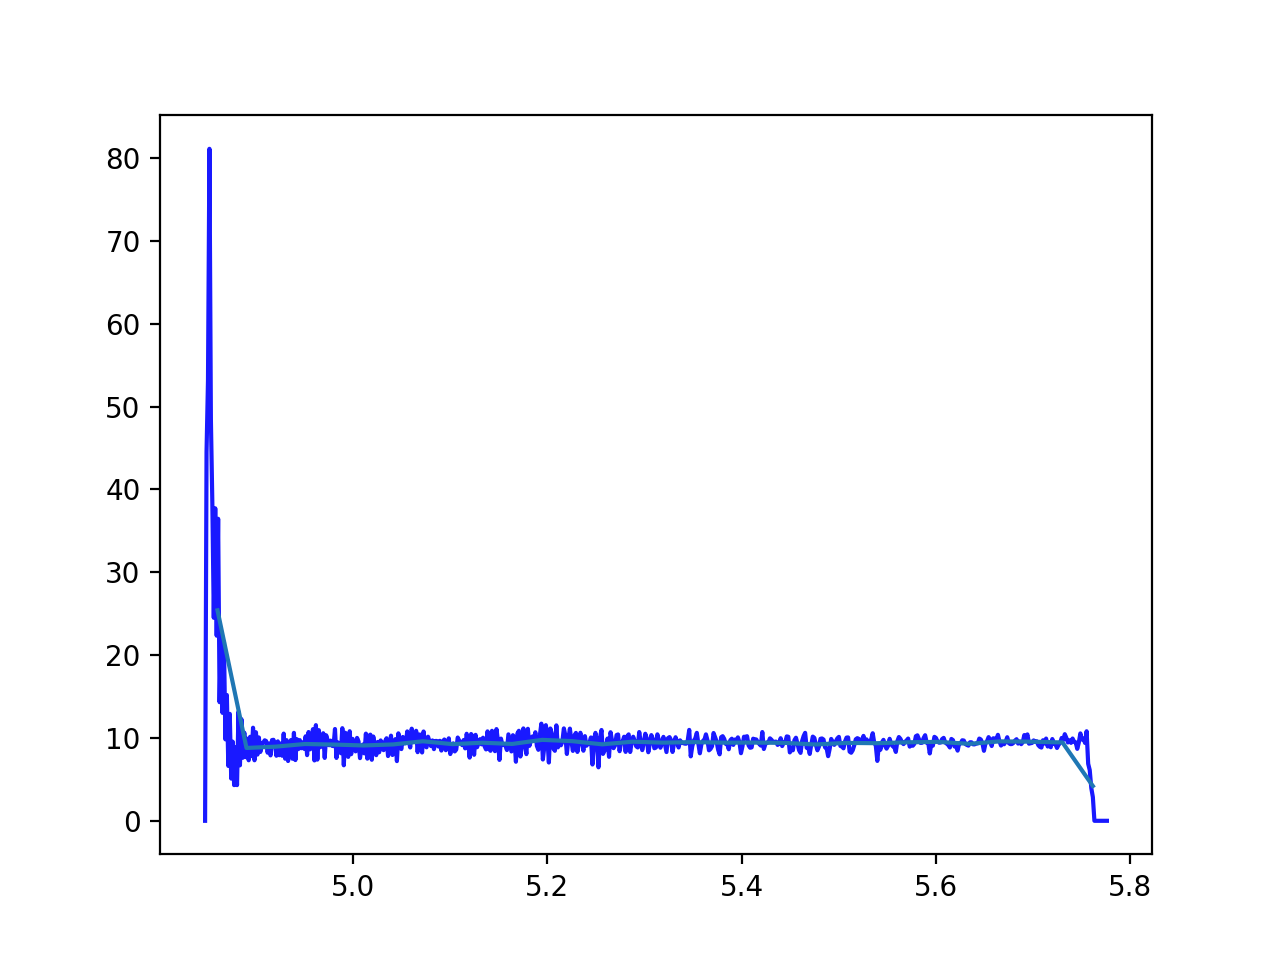

<IPython.core.display.Javascript object>


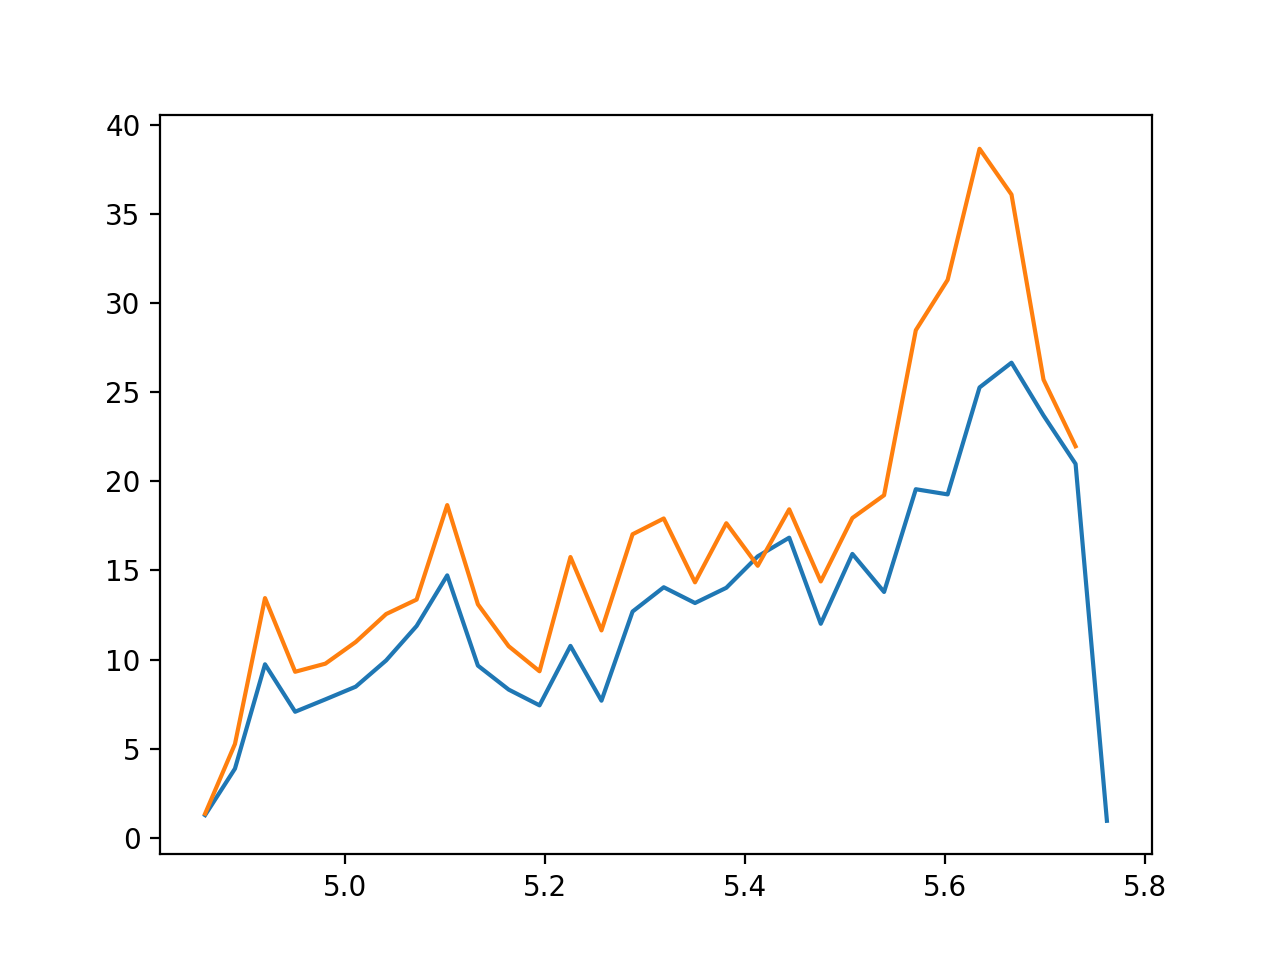

In [38]:
plt.figure()
plt.plot(wavelengths[band],1.2*aper_signals[band]/oversampling_dic[band],'b',alpha=0.9)
plt.plot(wav_apex,mean_apex)

plt.figure()
plt.plot(wav_apex,mean_apex/std_apex)
plt.plot(wav_opex,mean_opex/std_opex)

<IPython.core.display.Javascript object>


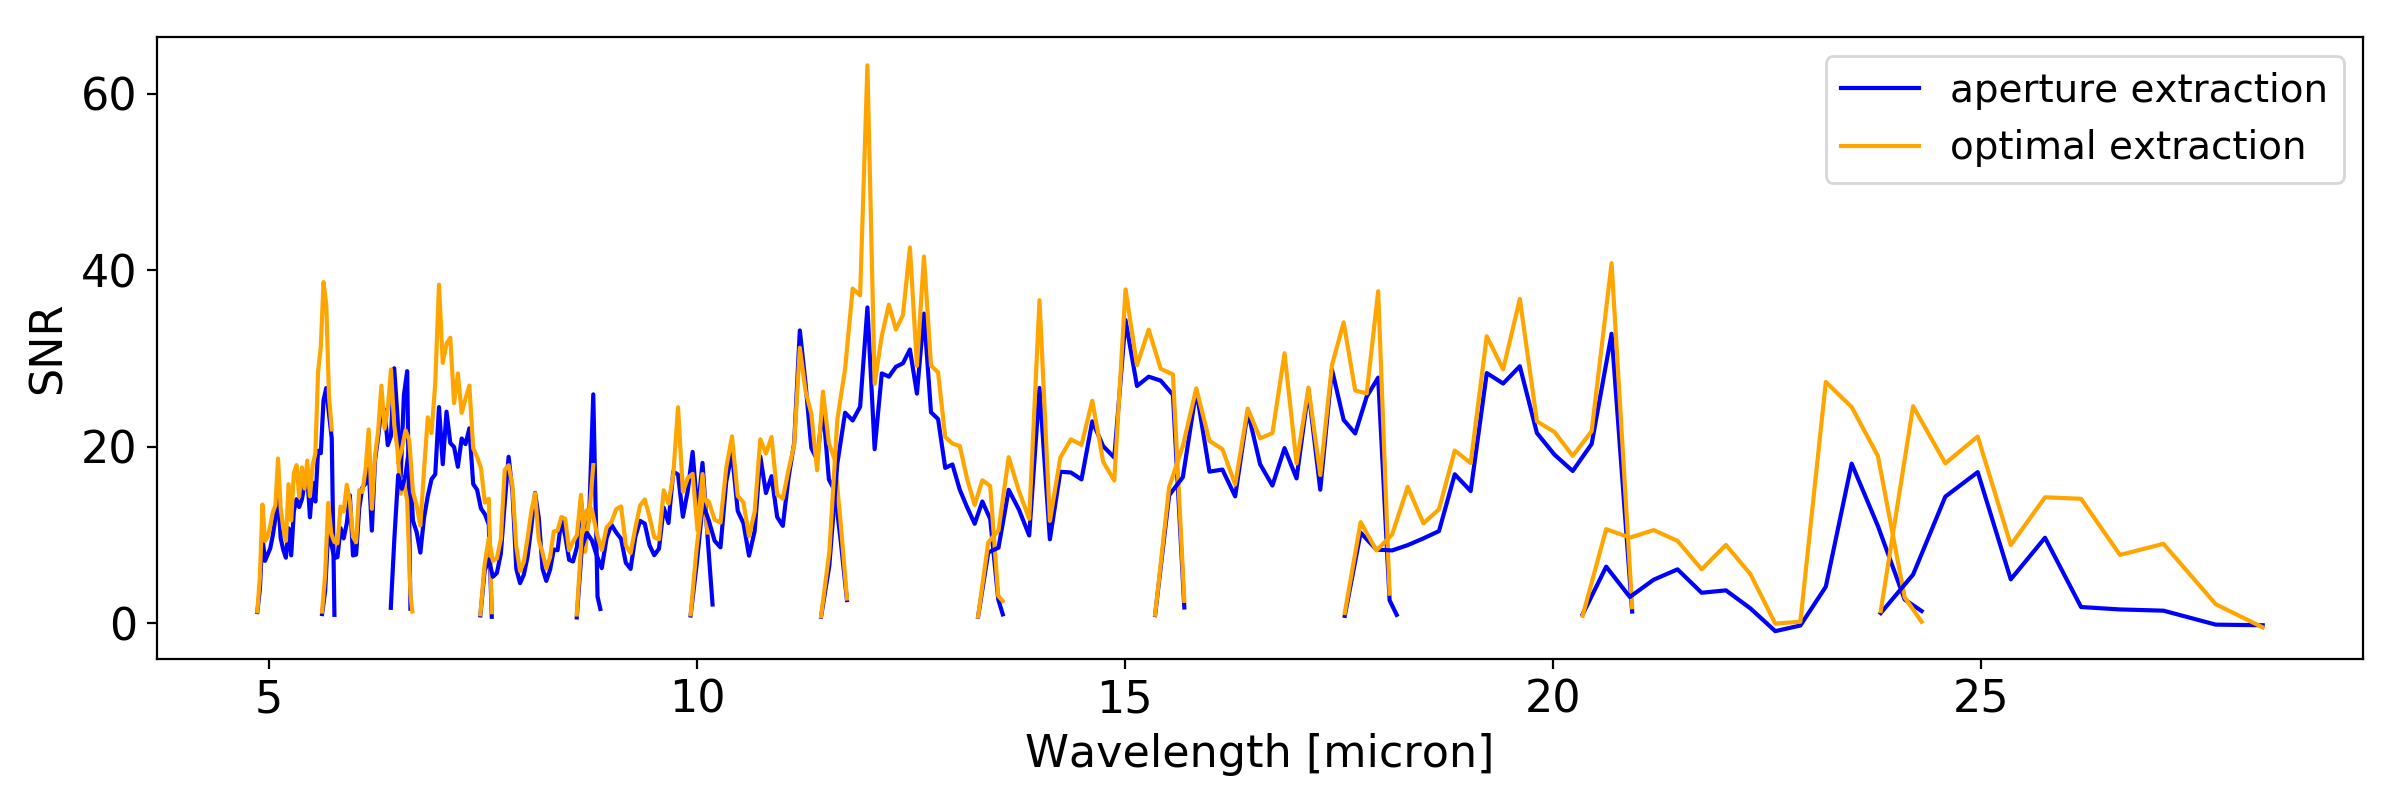

In [55]:
plt.figure(figsize=(12,4))
for band in bands:
    nBins = len(wavelengths[band])
    nPoints = 20

    counter = 0
    wav_apex,std_apex,mean_apex = [],[],[]
    while counter < nBins:
        wav_apex.append( np.mean(wavelengths[band][counter:counter+nPoints]) )
        std_apex.append( np.std( (1.2*aper_signals[band]/oversampling_dic[band])[counter:counter+nPoints] ) )
        mean_apex.append( np.mean( (1.2*aper_signals[band]/oversampling_dic[band])[counter:counter+nPoints] ) )
        counter+=nPoints
    wav_apex = np.array(wav_apex)
    std_apex = np.array(std_apex)
    mean_apex = np.array(mean_apex)

    counter = 0
    wav_opex,std_opex,mean_opex = [],[],[]
    while counter < nBins:
        wav_opex.append( np.mean(wavelengths[band][counter:counter+nPoints]) )
        std_opex.append( np.std( (opt_signals[band]/oversampling_dic[band])[counter:counter+nPoints] ) )
        mean_opex.append( np.mean( (opt_signals[band]/oversampling_dic[band])[counter:counter+nPoints] ) )
        counter+=nPoints
    wav_opex = np.array(wav_opex)
    std_opex = np.array(std_opex)
    mean_opex = np.array(mean_opex)

    plt.plot(wav_apex,mean_apex/std_apex,'b')
    plt.plot(wav_opex,mean_opex/std_opex,'orange')
legend_elements = [Line2D([0],[0],color='b',label='aperture extraction'),Line2D([0],[0],color='orange',label='optimal extraction')]
plt.legend(handles=legend_elements,loc='upper middle',fontsize=14)
plt.xlabel('Wavelength [micron]',fontsize=16)
plt.ylabel('SNR',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()